In [59]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import re

In [60]:
# Cargamos el csv original
raw_file = 'airbnb-listings.csv'
cleaned_file = 'airbnb-listings_cleaned.csv' # POR QUÉ CARGAMOS EL CLEANED?? Se suppone que este debería crearse al final del código, no?
df = pd.read_csv(raw_file, delimiter=";", low_memory=False)

# Primera limpieza del dataframe

In [61]:
# Filtramos las filas y nos quedamos solo con las que contienen datos de Madrid
madrid_condition = df['State'].astype(str).str.contains('Madrid')
df = df[madrid_condition]

In [62]:
# Variable con las columnas que vamos a utilizar
columns_to_keep = ['ID', 'Host ID', 'Host Since', 'Street', 'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude', \
                   'Amenities', 'Property Type', 'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee', 'Availability 365', \
                   'Review Scores Location', 'Cancellation Policy', 'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price', 'Monthly Price', 'Weekly Price']

# Nos quedamos solo con las columnas elegidas
df = df[columns_to_keep]
print(df.columns)

Index(['ID', 'Host ID', 'Host Since', 'Street', 'Neighbourhood',
       'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude',
       'Longitude', 'Amenities', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee',
       'Availability 365', 'Review Scores Location', 'Cancellation Policy',
       'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price',
       'Monthly Price', 'Weekly Price'],
      dtype='object')


# Conversión de tipos de datos

In [63]:
# Convertimos los datos de la columna Host Since en tipo fecha
host_since = df['Host Since']
host_since = list(map(pd.to_datetime, host_since))
df['Host Since'] = host_since

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13244\2064405049.py:3: UserWarning: Parsing '19/06/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  host_since = list(map(pd.to_datetime, host_since))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13244\2064405049.py:3: UserWarning: Parsing '24/01/2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  host_since = list(map(pd.to_datetime, host_since))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13244\2064405049.py:3: UserWarning: Parsing '31/10/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  host_since = list(map(pd.to_datetime, host_since))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13244\2064405049.py:3: UserWarning: Parsing '17/04/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  host_since = list(map(pd.to_dat

# Normalización de las columnas

### Zipcode

In [64]:
# Normalizamos los valores de la columna Zipcode que contiene códigos postales erróneos y valores nulos
replace_values = {'nan': np.nan, '-': np.nan, '28': np.nan, '-' : np.nan, '2802\n28012' : '28012', '28002\n28002': '28002', '28051\n28051' : '28051', \
                  'Madrid 28004': '28004', '2815' : '28015', '2805' : '28005'}

df = df.replace({'Zipcode': replace_values})

### Neighbourhood

In [65]:
# Cambiamos los valores nulos de la columna Neighbourhood por el valor correspondiente de la columna Neighbourhood Cleansed
df['Neighbourhood'] = df['Neighbourhood'].fillna(df['Neighbourhood Cleansed'])

# Eliminamos la columna Neighbourhood Cleansed
df = df.drop('Neighbourhood Cleansed', axis = 1)

# Comprobamos que no quedan valores nulos
df['Neighbourhood'].isna().value_counts()

False    13198
Name: Neighbourhood, dtype: int64

### Property Type

<AxesSubplot:>

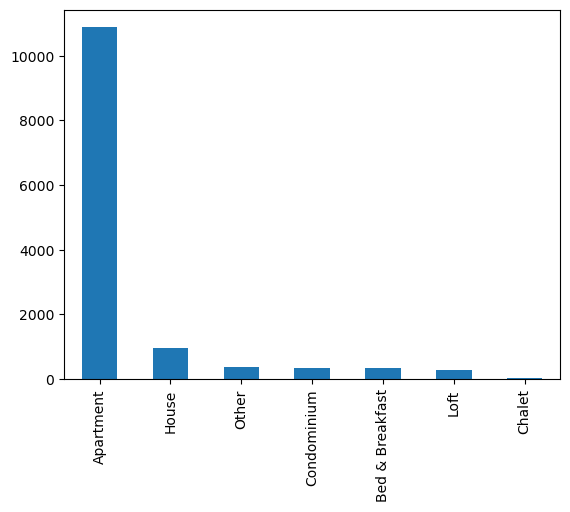

In [66]:
# Variable con los valores de Property Type que nos interesan (más comunes)
valid_property_types = ['House', 'Apartment', 'Bed & Breakfast', 'Condominium', 'Loft', 'Chalet', 'Hostal']

# Agrupamos los valores de Property Type y creamos un valor Other para el resto
property_types = df['Property Type']
property_types = property_types.map(lambda value: value if value in valid_property_types else 'Other')
df['Property Type'] = property_types

# Visualizamos el resultado
df['Property Type'].value_counts().plot.bar()

### Columnas de texto

In [67]:
# Analizamos qué columnas necesitan normalización textual
for column in df.columns:
    if df[column].dtype == object:
        print(column)

# Variable con dichas columnas
str_columns = ['Neighbourhood', 'City', 'State', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

# No he incluido Street porque yo la eliminaría, no es una calle, es una combinación de las columnas Neighbourhood, City, State, Zipcode y Country

Street
Neighbourhood
City
State
Zipcode
Latitude
Longitude
Amenities
Property Type
Room Type
Bed Type
Cancellation Policy


In [68]:
# Analizamos los caracteres no alfabéticos a conservar o a eliminar
for column in df.columns:
    if column in str_columns:
        temp_df = df[df[column].astype(str).str.contains('-|#|\.|,|;|:|_|&|/|Ç|\'|%|[|]|{|}|=|\?|¿|\(|\)|¡|!|\$|`\´|>|<|\||ª|º\\|@|\d|  ')]
        print(temp_df[column].unique())

['Fuencarral-el Pardo' 'Fuencarral-El Pardo']
['Madrid, Comunidad de Madrid, ES' 'Madrid, Vallecas (Fontarrón)'
 'Madrid, Comunidad de Madrid, ESPANA' 'las matas  madrid'
 'Delicias-Madrid' 'Centro, Madrid' 'Aravaca (Madrid)' 'Chueca, Madrid']
['Madrid, Spain' 'España,Madrid']
['Bed & Breakfast']
['Entire home/apt']
['Pull-out Sofa']
['super_strict_60' 'super_strict_30']


In [69]:
# Función para eliminar los caracteres no alfa-numéricos y los dobles espacios
def no_alfa_num(text):
    characters = '-|_|\(|\)|  '
    for character in text:
        match = re.search(characters, text)
        if match:
            text = text.replace(match.group(0), ' ')
    return text

# Función para normalizar tildes y eñes
def normalize(text):
    characters = (('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ñ', 'n'))
    for a, b in characters:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

In [70]:
# Normalización de las columnas de texto
for column in df.columns:
    if column in str_columns:
        column_normalized = list(map(normalize, list(map(no_alfa_num, df[column].astype(str)))))
        df[column] = column_normalized

df[str_columns]

,Neighbourhood,City,State,Property Type,Room Type,Bed Type,Cancellation Policy
3,Palacio,Madrid,Community of Madrid,Apartment,Private room,Real Bed,flexible
4,Palacio,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,strict
5,La Latina,Madrid,Community of Madrid,Apartment,Private room,Real Bed,flexible
6,Malasana,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
7,Palacio,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,moderate
...,...,...,...,...,...,...,...
14755,Malasana,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,flexible
14756,Malasana,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,moderate
14757,Malasana,Madrid,Madrid,Apartment,Entire home/apt,Real Bed,flexible
14758,Malasana,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict


### Amenities

<AxesSubplot:>

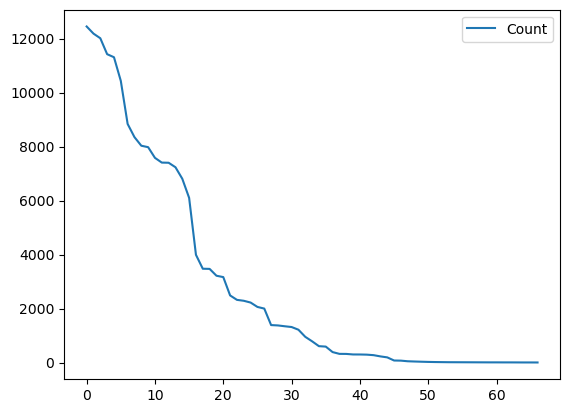

In [71]:
# Variable con todos los valores de la columna Amenities, separándolos por las comas
amenities_values = df['Amenities'].str.cat(sep=',').split(",")

# Inicializamos un diccionario para realizar un conteo de todos los valores de Amenities
amenities = {}
for amenitie in amenities_values:
    amenities[amenitie] = amenities.get(amenitie, 0) + 1

# Convertimos el diccionario en una lista de tuplas ordenada por el número de apariciones de cada amenitie
amenities = sorted(amenities.items(), key=lambda x: x[1], reverse=True)

# Visualizamos la frecuencia de las amenities
pd.DataFrame.from_records(amenities, columns=['Name', 'Count']).plot()

In [72]:
# Vemos todos los valores existentes en la columna Amenities
amenities = map(lambda value: value[0], amenities)
amenities = list(amenities)#[:10]
amenities

['Wireless Internet',
 'Kitchen',
 'Heating',
 'Essentials',
 'Washer',
 'TV',
 'Hangers',
 'Shampoo',
 'Elevator in building',
 'Family/kid friendly',
 'Iron',
 'Internet',
 'Hair dryer',
 'Air conditioning',
 'Laptop friendly workspace',
 'Buzzer/wireless intercom',
 'translation missing: en.hosting_amenity_50',
 'Smoking allowed',
 'First aid kit',
 '24-hour check-in',
 'translation missing: en.hosting_amenity_49',
 'Doorman',
 'Pets allowed',
 'Dryer',
 'Fire extinguisher',
 'Breakfast',
 'Smoke detector',
 'Carbon monoxide detector',
 'Wheelchair accessible',
 'Safety card',
 'Cable TV',
 'Lock on bedroom door',
 'Free parking on premises',
 'Pets live on this property',
 'Pool',
 'Suitable for events',
 'Private entrance',
 'Hot tub',
 'Indoor fireplace',
 'Cat(s)',
 'Dog(s)',
 'Self Check-In',
 'Gym',
 'Private living room',
 'Doorman Entry',
 'Bathtub',
 'Lockbox',
 'Room-darkening shades',
 'Other pet(s)',
 'Crib',
 'Smartlock',
 'Pack ’n Play/travel crib',
 'Window guards',
 

In [73]:
# Variable con la columna Amenities y sin valores nulos
amenities_df = df['Amenities'].fillna('')

# Variable con el nombre de todos los valores de Amenities
valid_amenities = amenities

# Creamos un dataframe con cada valor de Amenitie como nombre de columna y valores True (si la propiedad tiene la amenitie) o False (si no la tiene)
# Además, añadimos una nueva columna con un conteo de cuántas amenities tiene cada propiedad
for index, row_amenities in enumerate(amenities_df):
    row_amenities = row_amenities.split(',')
    row_amenities = list(filter(lambda value: value in valid_amenities, row_amenities))

    df.loc[index, 'Amenities Count'] = len(row_amenities)

    for amenitie in row_amenities:
        if amenitie not in df.columns:
            df[amenitie] = False
        df.loc[index, amenitie] = True

df[np.append(np.array(valid_amenities), 'Amenities Count')]

,Wireless Internet,Kitchen,Heating,Essentials,Washer,TV,Hangers,Shampoo,Elevator in building,Family/kid friendly,...,Babysitter recommendations,Outlet covers,Free parking on street,Game console,Washer / Dryer,Stair gates,Table corner guards,Paid parking off premises,Changing table,Amenities Count
3,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,23.0
4,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,19.0
5,True,True,True,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,14.0
6,True,True,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,13.0
7,True,True,True,True,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12926,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
12960,True,True,True,True,True,True,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
13013,True,True,True,True,True,NaN,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
13115,True,True,True,NaN,True,NaN,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0


In [74]:
# Creamos un dataframe para ver la variación del precio medio de las propiedades en función de si tienen una amenitie concreta o no
amenities_df = pd.DataFrame()
for amenitie in valid_amenities:
    amenities_df[amenitie] = df.groupby(amenitie)['Price'].mean()

amenities_df.rename_axis('', inplace=True)
amenities_df

,Wireless Internet,Kitchen,Heating,Essentials,Washer,TV,Hangers,Shampoo,Elevator in building,Family/kid friendly,...,Keypad,Babysitter recommendations,Outlet covers,Free parking on street,Game console,Washer / Dryer,Stair gates,Table corner guards,Paid parking off premises,Changing table
,,,,,,,,,,,,,,,,,,,,,
False,65.505736,65.251664,66.613787,64.608370,64.847947,65.938413,65.164227,65.192794,65.141780,65.401465,...,65.704142,65.742851,65.740443,65.742471,65.734092,65.741392,65.735457,65.737676,65.737070,65.732919
True,65.774142,65.832571,65.536685,66.055902,65.999113,65.649353,66.110999,66.143486,66.222099,66.011001,...,120.714286,44.833333,47.000000,45.666667,63.250000,30.333333,58.750000,46.666667,49.333333,68.500000


<AxesSubplot:xlabel='Amenities Count'>

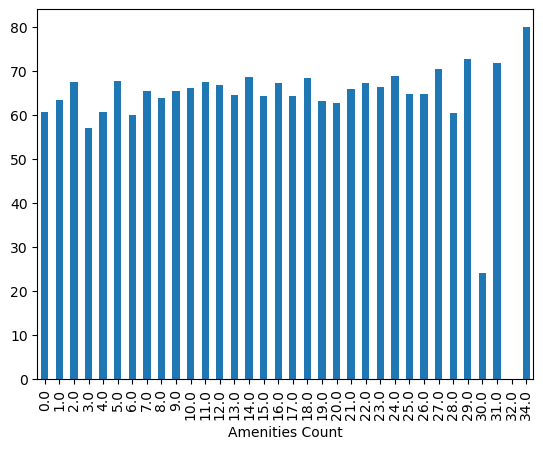

In [13]:
# Visualizamos la variación del precio medio de las propiedades en función de cuántas amenities totales tienen
df.groupby('Amenities Count')['Price'].mean().plot.bar()

<AxesSubplot:xlabel='Amenities Count'>

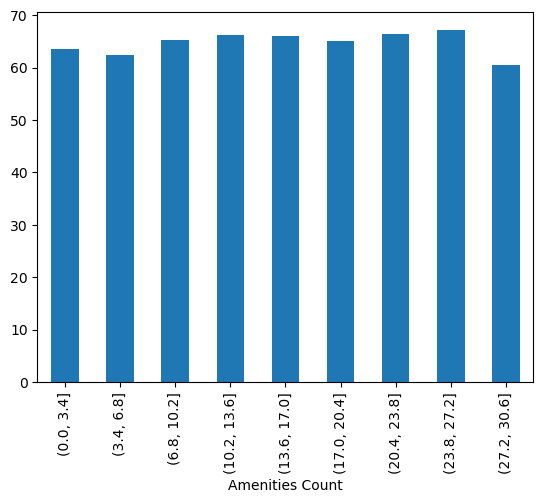

In [75]:
# Visualizamos la variación del precio medio de las propiedades en función de cuántas amenities totales tienen, agrupando el conteo en 10 grupos
steps = 10
stept = df['Amenities Count'].max() / steps
steps = np.arange(0, df['Amenities Count'].max(), stept)
groups = pd.cut(df['Amenities Count'], steps)
df.groupby(groups)['Price'].mean().plot.bar()

# Maxs and function

In [ ]:
max_bathrooms = 3
max_bedrooms = 3
max_beds = 7

def format_max(max_value):
    return lambda value: str(value) if value < max_value else f'{max_value}+'

def calculate_ocupacy(reviews_month, min_nights, availability):
    return reviews_month * min_nights * 12 / availability

# Bathrooms

In [ ]:
format_max(max_bathrooms)(8)

In [ ]:
bathrooms = df['Bathrooms']
bathrooms = bathrooms.map(format_max(max_bathrooms))
df['Bathrooms'] = bathrooms

In [ ]:
df['Bathrooms'].value_counts().sort_index().plot()

# Bedrooms

In [ ]:
bedrooms = df['Bedrooms']
bedrooms = bedrooms.map(format_max(max_bedrooms))
df['Bedrooms'] = bedrooms

In [ ]:
df['Bedrooms'].value_counts().sort_index().plot()

# Beds

In [ ]:
beds = df['Beds']
beds = beds.map(format_max(max_beds))
df['Beds'] = beds

In [ ]:
df['Beds'].value_counts().sort_index().plot()

# https://medium.datadriveninvestor.com/airbnb-listings-analysis-in-toronto-october-2018-2a5358bae007
# Ocupacy

In [ ]:
reviews = df['Reviews per Month'].fillna(0)
nights = df['Minimum Nights'].fillna(0)
availability = df['Availability 365'].fillna(0).map(lambda value: value if value != 0 else 9999999)

df['Ocupacy'] = calculate_ocupacy(reviews, nights, availability)

steps = np.arange(0, 1.01, 0.1)
groups = pd.cut(df['Ocupacy'], steps)
df.groupby(groups).size().plot()

# Cleaning Fee

In [ ]:
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)
df['Cleaning Fee'].value_counts()

steps = 50
stept = df['Cleaning Fee'].max() / steps
steps = np.arange(0, df['Cleaning Fee'].max(), stept)
groups = pd.cut(df['Cleaning Fee'], steps)
df.groupby(groups).size().plot()

In [ ]:
df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False).head(10).plot.bar()

In [ ]:
df.groupby('Neighbourhood')['Weekly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

In [ ]:
df.groupby('Neighbourhood')['Monthly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

In [ ]:
df.groupby('Neighbourhood')['Ocupacy'].mean().sort_values(ascending=False).head(20).plot.bar()

In [ ]:
df.groupby('Neighbourhood').size().sort_values(ascending=True).head(20).plot.bar()

In [ ]:
df.groupby(['Neighbourhood', 'Ocupacy']).apply(list)